In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.constants import golden_ratio
from time import time
conj_ratio = 2 - golden_ratio

def golden_section(f, xl, xr, eps, criterion="function"):
    error, xll, xrr = eps + 1, xl + conj_ratio * (xr - xl), xr + conj_ratio * (xl - xr)
    fll, frr = f(xll), f(xrr)
    while error > eps:
        if fll < frr:
            xll, xrr, xr = xl + conj_ratio * (xrr - xl), xll, xrr
            fll, frr = f(xll), fll
        else:
            xl, xll, xrr = xll, xrr, xr + conj_ratio * (xll - xr)
            fll, frr = frr, f(xrr)
        error = np.linalg.norm(xr - xl) if criterion == "point" else abs(frr - fll)
    x = (xl + xr) / 2
    return x, f(x)

def frank_wolfe_argmin(f, df, x0, eps, UBs=(None,None), EQs=(None,None), criterion="function", method="interior-point"):
    A_ub, b_ub = UBs
    A_eq, b_eq = EQs
    t, error, x, fs, dfs = [time()], eps + 1, x0, [f(x0)], [np.linalg.norm(df(x0))]
    while t[-1] - t[0] < 60 and (error < 0 or error > eps):
        grad = df(x)
        s = linprog(c=grad,
                A_ub=A_ub, b_ub=b_ub,
                A_eq=A_eq, b_eq=b_eq,
                method=method).x
        sx = s - x
        x0 = x
        x, fnew = golden_section(f, x, s, eps, criterion)
        fs.append(fnew)
        dfs.append(np.linalg.norm(grad))
        if criterion == "function":
            error = fs[-2] - fs[-1]
        elif criterion == "point":
            error = np.linalg.norm(x - x0)
        else:
            error = np.linalg.norm(grad)
        t.append(time())
    return x, fs, dfs, np.array(t) - t[0]

def frank_wolfe_reciproc(f, df, x0, eps, UBs=(None,None), EQs=(None,None), criterion="function", method="interior-point"):
    A_ub, b_ub = UBs
    A_eq, b_eq = EQs
    t, error, x, fs, dfs, k = [time()], eps + 1, x0, [f(x0)], [np.linalg.norm(df(x0))], 0
    while t[-1] - t[0] < 60 and (error < 0 or error > eps):
        grad = df(x)
        s = linprog(c=grad,
                A_ub=A_ub, b_ub=b_ub,
                A_eq=A_eq, b_eq=b_eq,
                method=method).x
        
        x0, x = x, x + (2 / (k + 2)) * (s - x)
        fs.append(f(x))
        dfs.append(np.linalg.norm(grad))
        k += 1
        
        if criterion == "function":
            error = fs[-2] - fs[-1]
        elif criterion == "point":
            error = np.linalg.norm(x - x0)
        else:
            error = np.linalg.norm(grad)
        t.append(time())
    return x, fs, dfs, np.array(t) - t[0]

def frank_wolfe_adaptive(f, df, x0, eps, UBs=(None,None), EQs=(None,None), criterion="function", method="interior-point"):
    A_ub, b_ub = UBs
    A_eq, b_eq = EQs
    t, error, x, fs, dfs, L = [time()], eps + 1, x0, [f(x0)], [np.linalg.norm(df(x0))], -1
    while t[-1] - t[0] < 60 and (error < 0 or error > eps):
        grad = df(x)
        s = linprog(c=grad,
                A_ub=A_ub, b_ub=b_ub,
                A_eq=A_eq, b_eq=b_eq,
                method=method).x
        
        x0 = x
        direction = s - x
        direction /= np.linalg.norm(direction)
        if L >= 0:
            x = x0 + L * direction
            fcurr = f(x)
            while fcurr > fs[-1]:
                L /= 2
                x = x0 + L * direction
                fcurr = f(x)
        else:
            x, fcurr = golden_section(f, x, s, eps, criterion)
            L = np.linalg.norm(x - x0)
        L *= 2
        fs.append(fcurr)
        dfs.append(np.linalg.norm(grad))
        
        if criterion == "function":
            error = fs[-2] - fs[-1]
        elif criterion == "point":
            error = np.linalg.norm(x - x0)
        else:
            error = np.linalg.norm(grad)
        t.append(time())
    return x, fs, dfs, np.array(t) - t[0]

In [180]:
def normalize_matrix(A, low, upp):
    cl, cr = 1.0, 1.0
    detA = abs(np.linalg.det(A))
    while detA > low:
        if detA > upp:
            cr = cl
        cl /= 2
        detA = abs(np.linalg.det(cl * A))
    c = (cl + cr) / 2
    detA = abs(np.linalg.det(c * A))
    while not low <= detA <= upp:
        if detA > upp:
            c, cr = (c + cl) / 2, c
        else:
            cl, c = c, (c + cr) / 2
        detA = abs(np.linalg.det(c * A))
    return c * A

def simplex_rand(n):
    if n == 1:
        return np.random.rand(1)
    x = np.random.rand(2)
    if x[0] + x[1] > 1:
        x = 1 - x
    for i in range(3, n+1):
        xn1 = (1 - np.random.rand()) ** (1 / i)
        x = np.append(xn1 * x, 1 - xn1)
    return x

def random_simplex_domain(n, sigma=1, with_zero=False):
    A = np.append(-np.eye(n), np.ones((1, n)), axis=0)
    b = np.zeros(n+1)
    b[-1] = 1
    x0, xmin = simplex_rand(n), simplex_rand(n)
    # y = Dx + c
    D = sigma * normalize_matrix(np.random.randn(n, n), 0.5, 2.0)
    c = -(D @ np.full(n, 1/(n+1))) if with_zero else sigma * np.random.randn(n)
    x0, xmin = D @ x0 + c, D @ xmin + c
    A = A @ np.linalg.inv(D)
    b += A @ c
    if with_zero:
        xmin = np.zeros(n)
    return A, b, x0, xmin

def random_hypercube_domain(n, sigma=1, with_zero=False):
    A = np.append(-np.eye(n), np.eye(n), axis=0)
    b = np.append(np.zeros(n), np.ones(n))
    x0, xmin = np.random.rand(n), np.random.rand(n)
    # y = Dx + c
    D = sigma * normalize_matrix(np.random.randn(n, n), 0.5, 2.0)
    c = -(D @ np.full(n, 1/(n+1))) if with_zero else sigma * np.random.randn(n)
    x0, xmin = D @ x0 + c, D @ xmin + c
    A = A @ np.linalg.inv(D)
    b += A @ c
    if with_zero:
        xmin = np.zeros(n)
    return A, b, x0, xmin

def random_quadratic_target(xmin):
    n = len(xmin)
    A = np.random.randn(n, n)
    A = normalize_matrix(A @ A.T, 0.01, 100.0)
    b = A @ xmin
    A2 = A / 2
    return (lambda x: A2 @ x @ x - b @ x, lambda x: A @ x - b)

def random_quadratic_simplex_problem(n, eps, sigma=1):
    A, b, x0, xmin = random_simplex_domain(n, sigma, with_zero=True)
    f, df = random_quadratic_target(xmin)
    return (f, df, x0, eps, (A, b), (None, None)), xmin

def random_quadratic_hypercube_problem(n, eps, sigma=1):
    A, b, x0, xmin = random_hypercube_domain(n, sigma, with_zero=True)
    f, df = random_quadratic_target(xmin)
    return (f, df, x0, eps, (A, b), (None, None)), xmin

def random_power_simplex_problem(p, w, eps, sigma=1):
    A, b, x0, xmin = random_simplex_domain(len(w), sigma, True)
    w = np.array(w)
    pw = p * w
    return (lambda x: w @ (abs(x) ** p), lambda x: pw * (abs(x) ** (p-1)), x0, eps, (A, b), (None, None)), xmin

In [80]:
def test_methods(problem, xmin, criterion="function", method="interior-point"):
    x_rec, fs_rec, dfs_rec, t_rec = frank_wolfe_reciproc(*problem, criterion, method)
    x_arm, fs_arm, dfs_arm, t_arm = frank_wolfe_argmin(*problem, criterion, method)
    x_ada, fs_ada, dfs_ada, t_ada = frank_wolfe_adaptive(*problem, criterion, method)
    
    fmin = problem[0](xmin)
    fs = [fs_rec, fs_arm, fs_ada]
    dfs = [dfs_rec, dfs_arm, dfs_ada]
    ts = [t_rec, t_arm, t_ada]
    method_names = ["2 / (k + 2)", "Argmin", "Adaptive"]
    
    fig, (axf, axdf, axt) = plt.subplots(3, 3)
    fig.set_size_inches(16, 16)
    for i in range(3):
        axf[i].set_title(method_names[i], font={"size": 20})
        axdf[i].set_title("Norm of gradient")
        axt[i].set_title("Time spent")
    
        axf[i].set_xlabel("Number of iterations, k")
        axdf[i].set_xlabel("Number of iterations, k")
        axt[i].set_xlabel("Number of iterations, k")
    
        axf[i].set_ylabel("Error")
        axdf[i].set_ylabel("Gradient norm")
        axt[i].set_ylabel("Time, s")
    
        axf[i].semilogy(fs[i] - fmin, label=method_names[i])
        axdf[i].semilogy(dfs[i], label=method_names[i])
        axt[i].plot(ts[i], label=method_names[i])
    
    plt.show()
    return fmin, xmin, [x_rec, x_arm, x_ada]

C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:52: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:28: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:77: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,


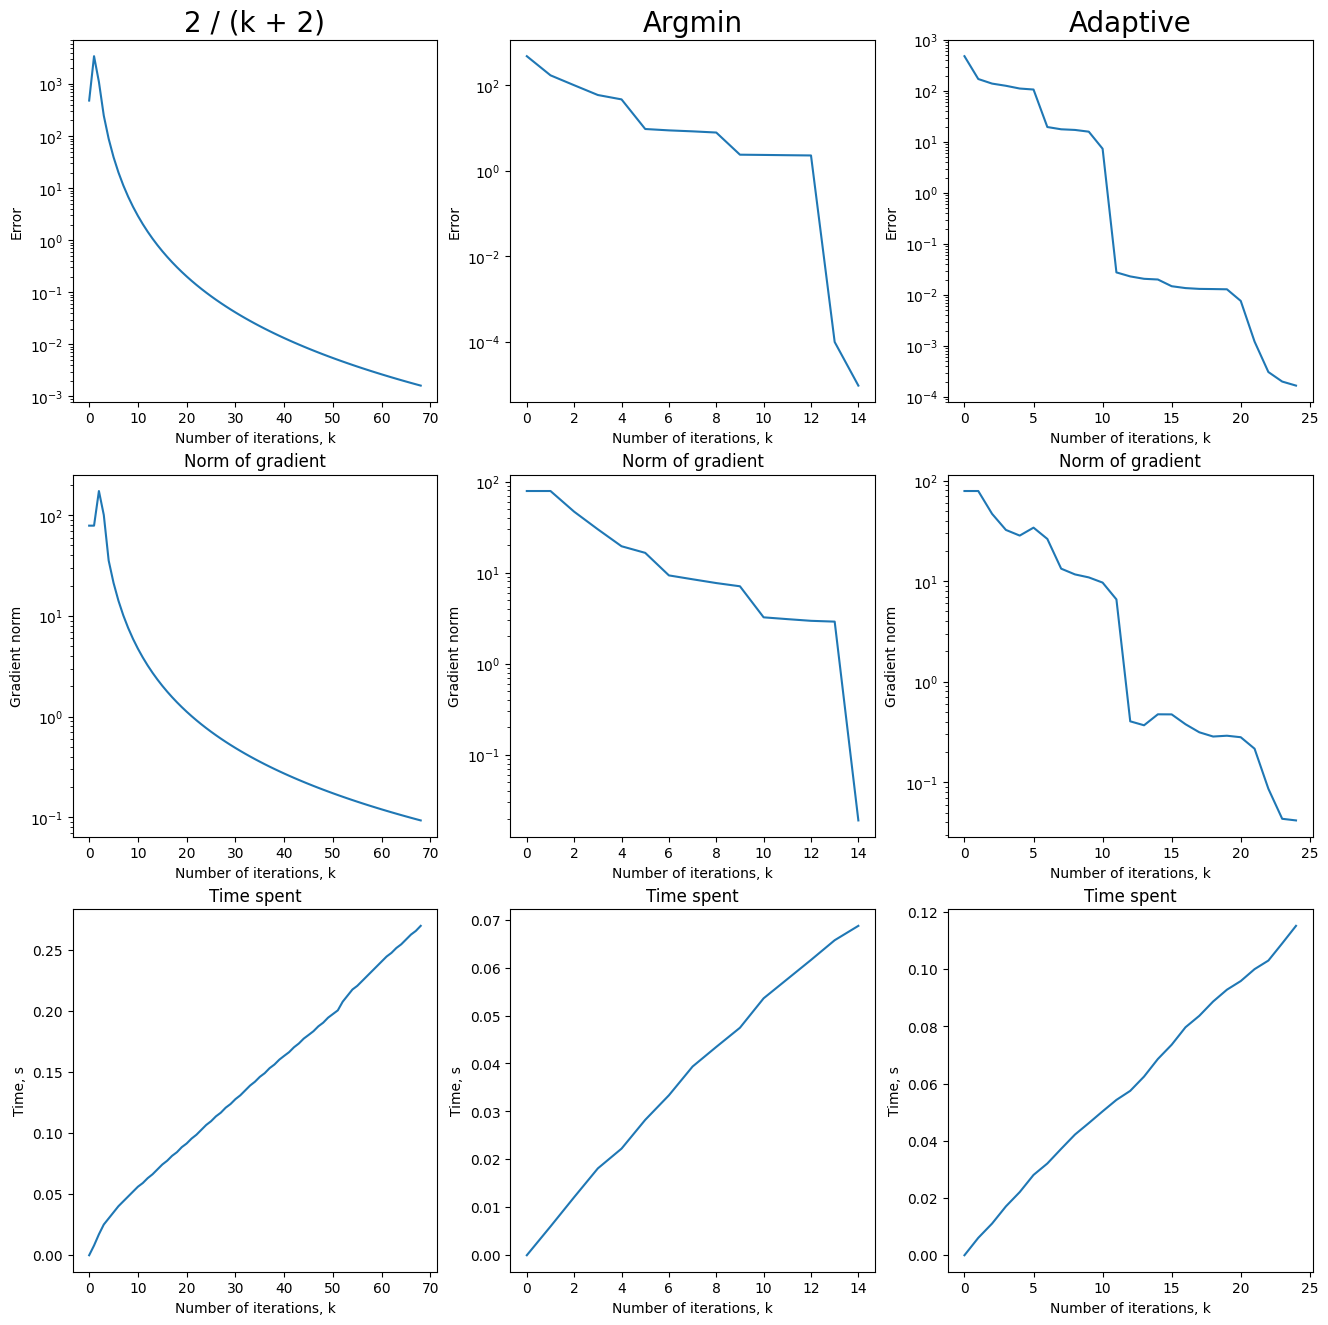

(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 [array([2.46077496e-02, 1.23234724e-02, 1.27928363e-02, 2.02007670e-02,
         2.72599827e-03, 1.38175960e-02, 6.40392837e-10, 1.20689545e-02,
         7.29230485e-03, 1.05091545e-02]),
  array([0.00083375, 0.00283014, 0.00114706, 0.00117254, 0.00024442,
         0.00215087, 0.00024537, 0.00029605, 0.00036707, 0.00014444]),
  array([ 0.00248453,  0.00296678,  0.00209514,  0.00583622, -0.00218688,
          0.0144461 ,  0.00966697,  0.00035138, -0.00078694, -0.00485113])])

In [191]:
problem, xmin = random_quadratic_simplex_problem(10, 0.0001, 100)
test_methods(problem, xmin)

C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:52: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:28: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:77: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,


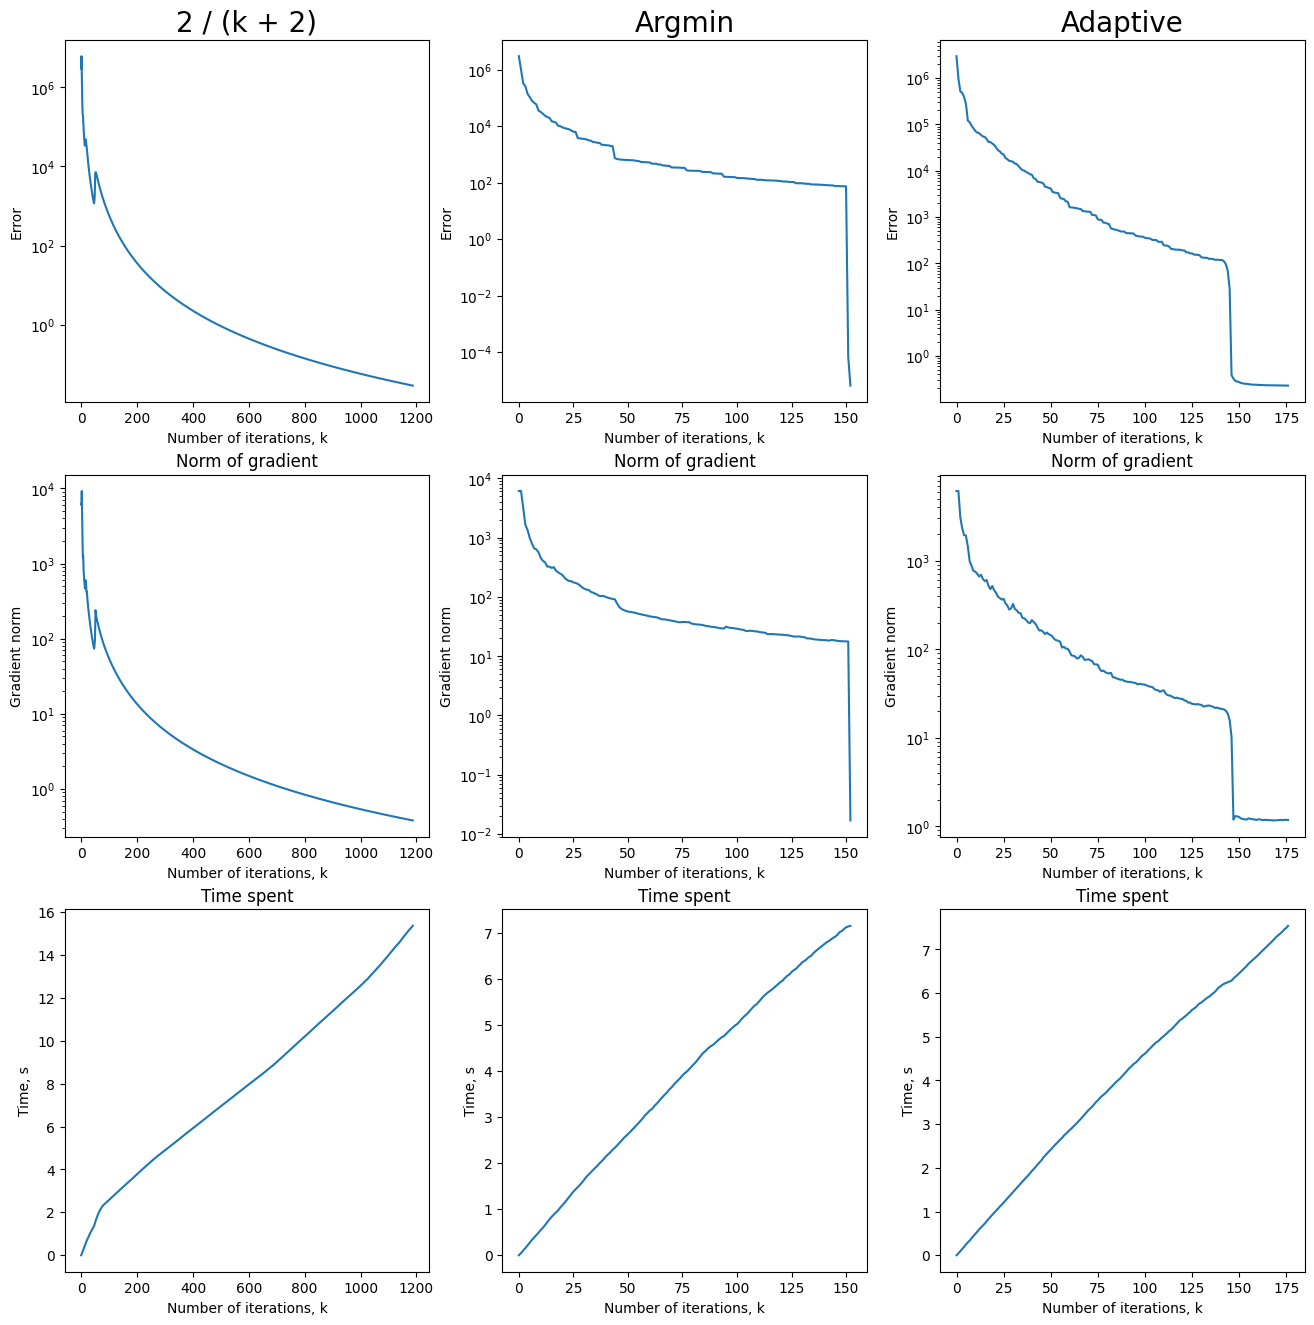

(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 [array([4.30403749e-02, 1.68958707e-02, 4.01490936e-02, 5.07022296e-02,
         7.45454102e-03, 3.55148681e-02, 2.04153758e-02, 2.78803505e-02,
         3.21590753e-02, 4.84418184e-10, 2.97132237e-02, 1.23339106e-02,
         6.86630715e-02, 1.99368199e-02, 2.65825212e-02, 1.25781295e-02,
         1.40449159e-02, 5.79364304e-02, 5.28113853e-03, 4.48218501e-04,
         1.31265909e-02, 6.10803214e-03, 4.18417684e-02, 2.68488896e-02,
         4.26142004e-04, 3.43878040e-02, 4.56075003e-03, 6.56198432e-02,
         6.02381562e-03, 4.041701

In [192]:
problem, xmin = random_quadratic_simplex_problem(100, 0.0001, 10000)
test_methods(problem, xmin)

C:\Users\Damir\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:52: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:28: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:77: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,


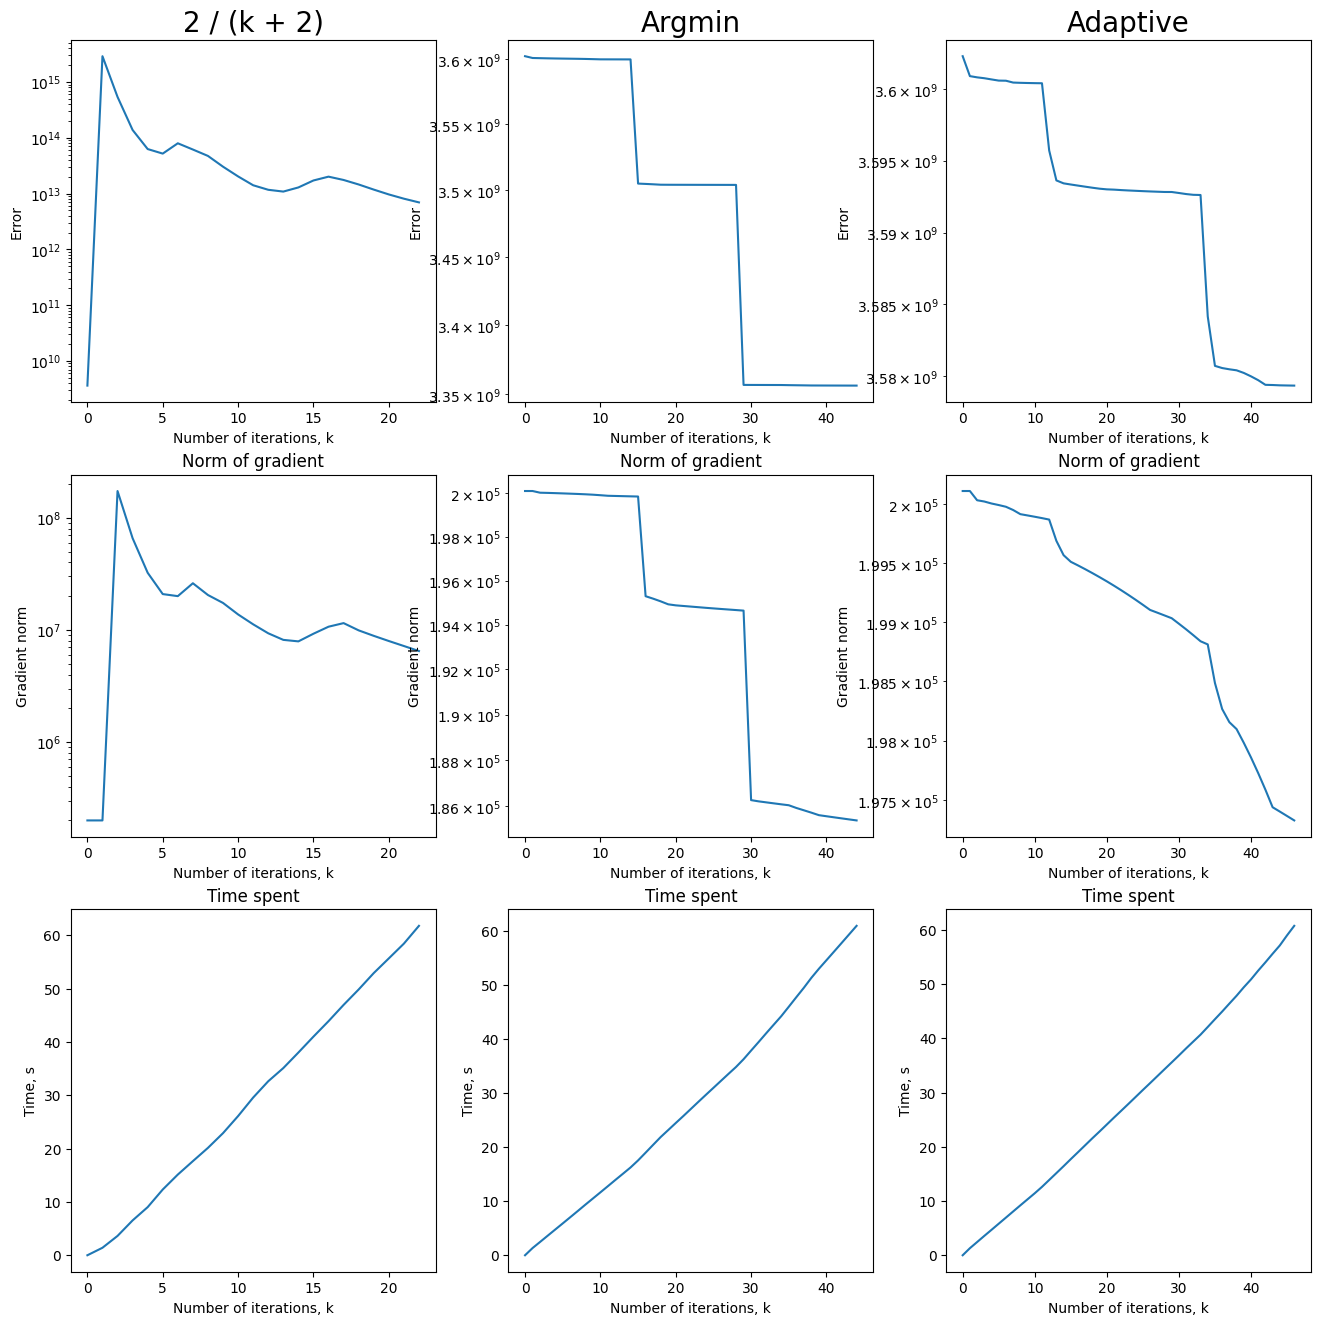

(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [193]:
problem, xmin = random_quadratic_simplex_problem(1000, 0.0001, 1000000)
test_methods(problem, xmin)

C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:52: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:28: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:77: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,


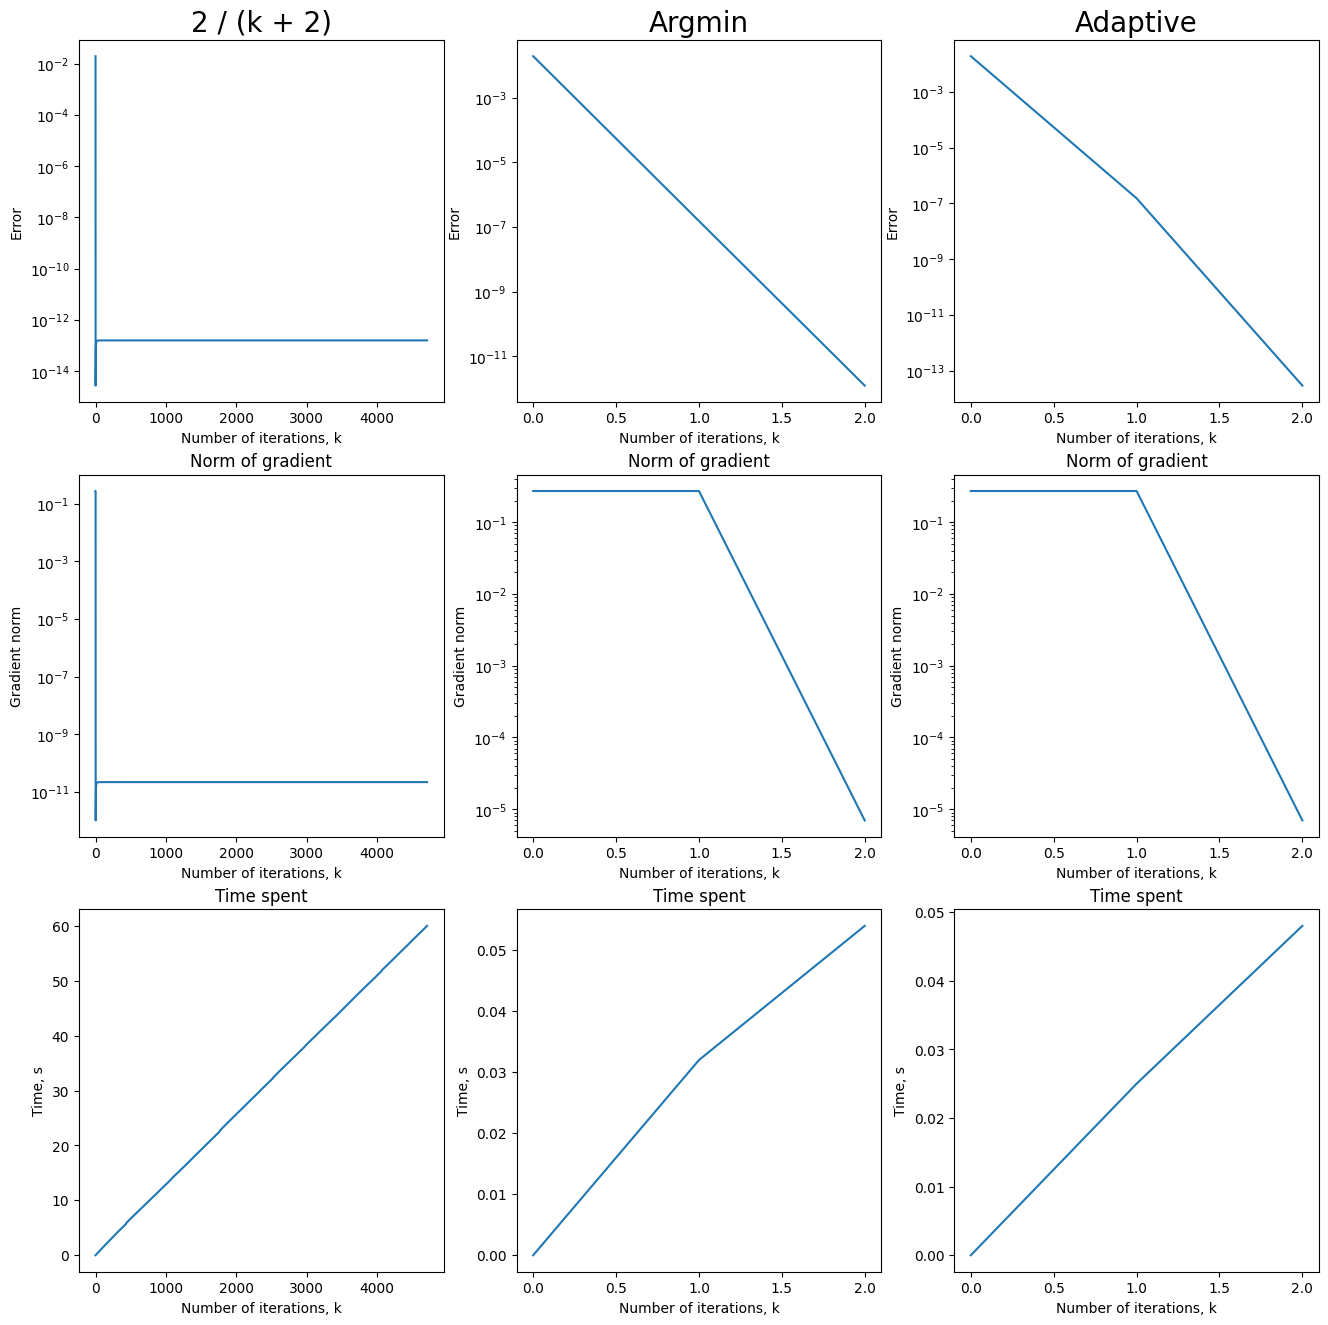

(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 [array([0.01510715, 0.01267895, 0.01477752, 0.01712926, 0.01158692,
         0.01128444, 0.01270777, 0.02033219, 0.01350495, 0.02104349,
         0.01097979, 0.02240666, 0.01102758, 0.01442014, 0.01478196,
         0.01181785, 0.01589762, 0.01704544, 0.0147014 , 0.01282847,
         0.01635387, 0.01021109, 0.02109924, 0.01330984, 0.02407362,
         0.01278572, 0.02890176, 0.02899826, 0.01301253, 0.01049132,
         0.01456808, 0.016064  , 0.01304637, 0.01370063, 0.01842306,
         0.01580362, 0.01744533, 0.02553733, 0.01421725, 0.01

In [194]:
problem, xmin = random_power_simplex_problem(10, abs(np.random.randn(100) * 100), 0.0001, 10)
test_methods(problem, xmin)

C:\Users\Damir\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:52: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:28: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:77: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,


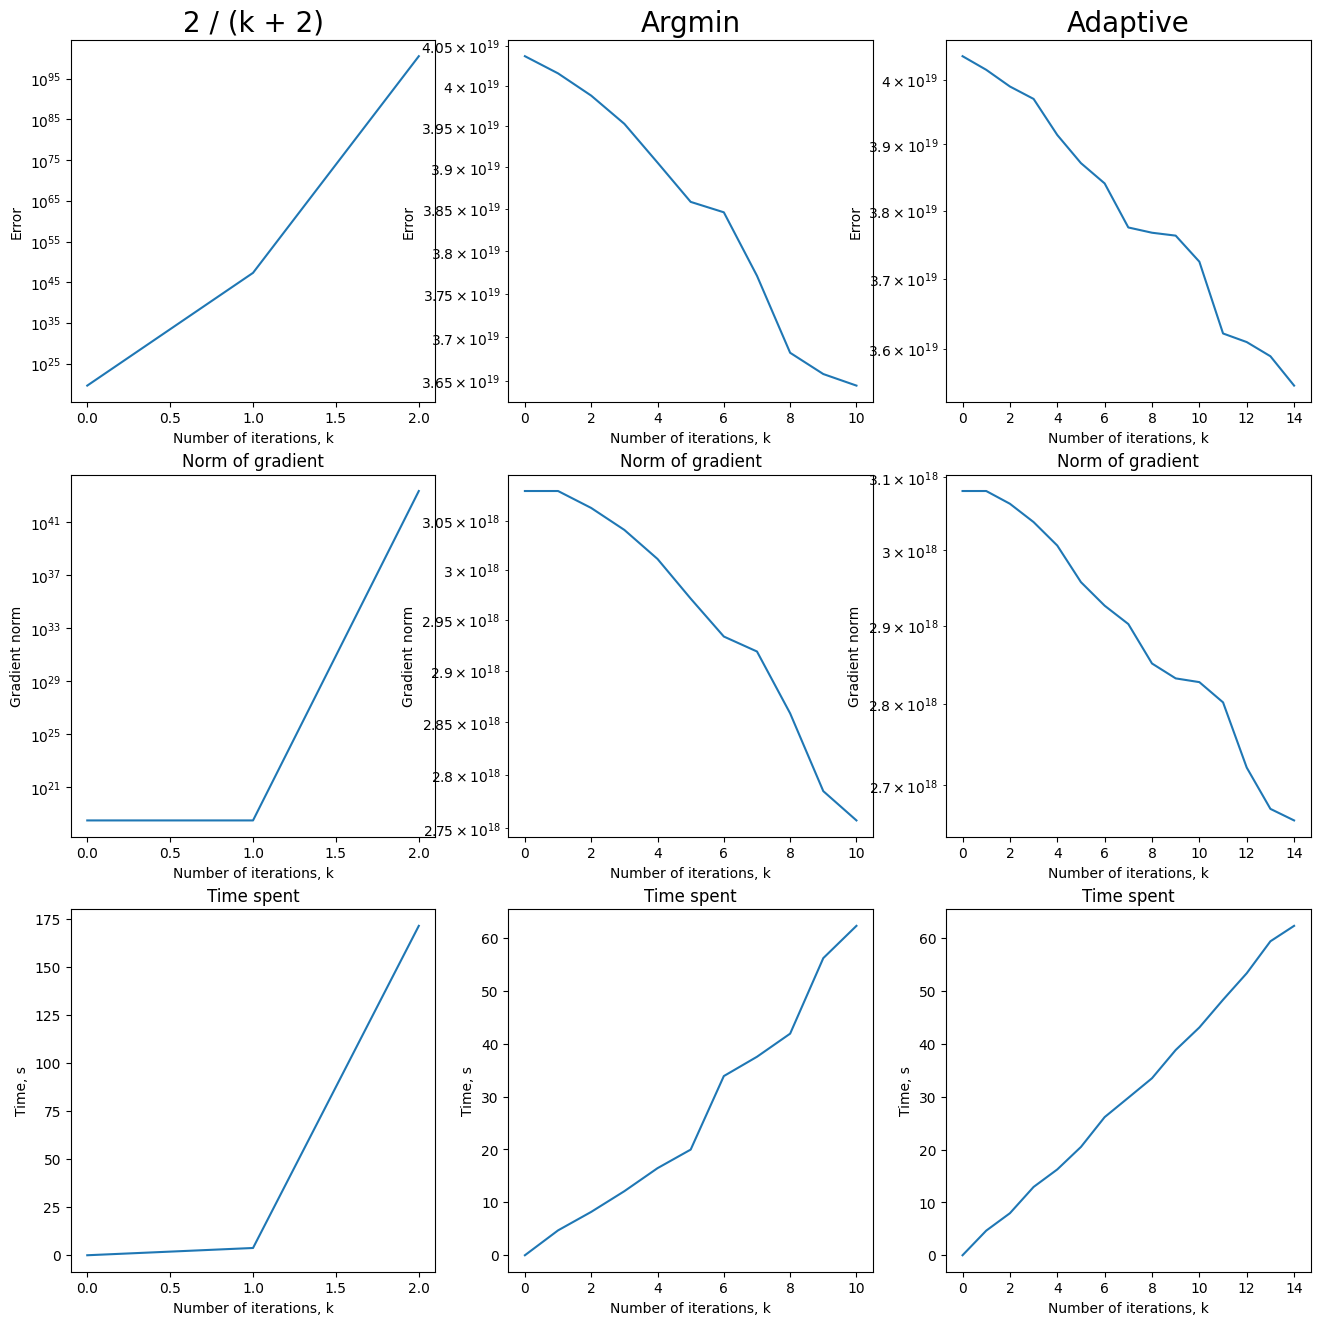

(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [195]:
problem, xmin = random_power_simplex_problem(10, abs(np.random.randn(1000) * 100), 0.0001, 10000)
test_methods(problem, xmin)

C:\Users\Damir\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:52: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:28: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,
C:\Users\Damir\AppData\Local\Temp\ipykernel_13748\1616868464.py:77: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  s = linprog(c=grad,


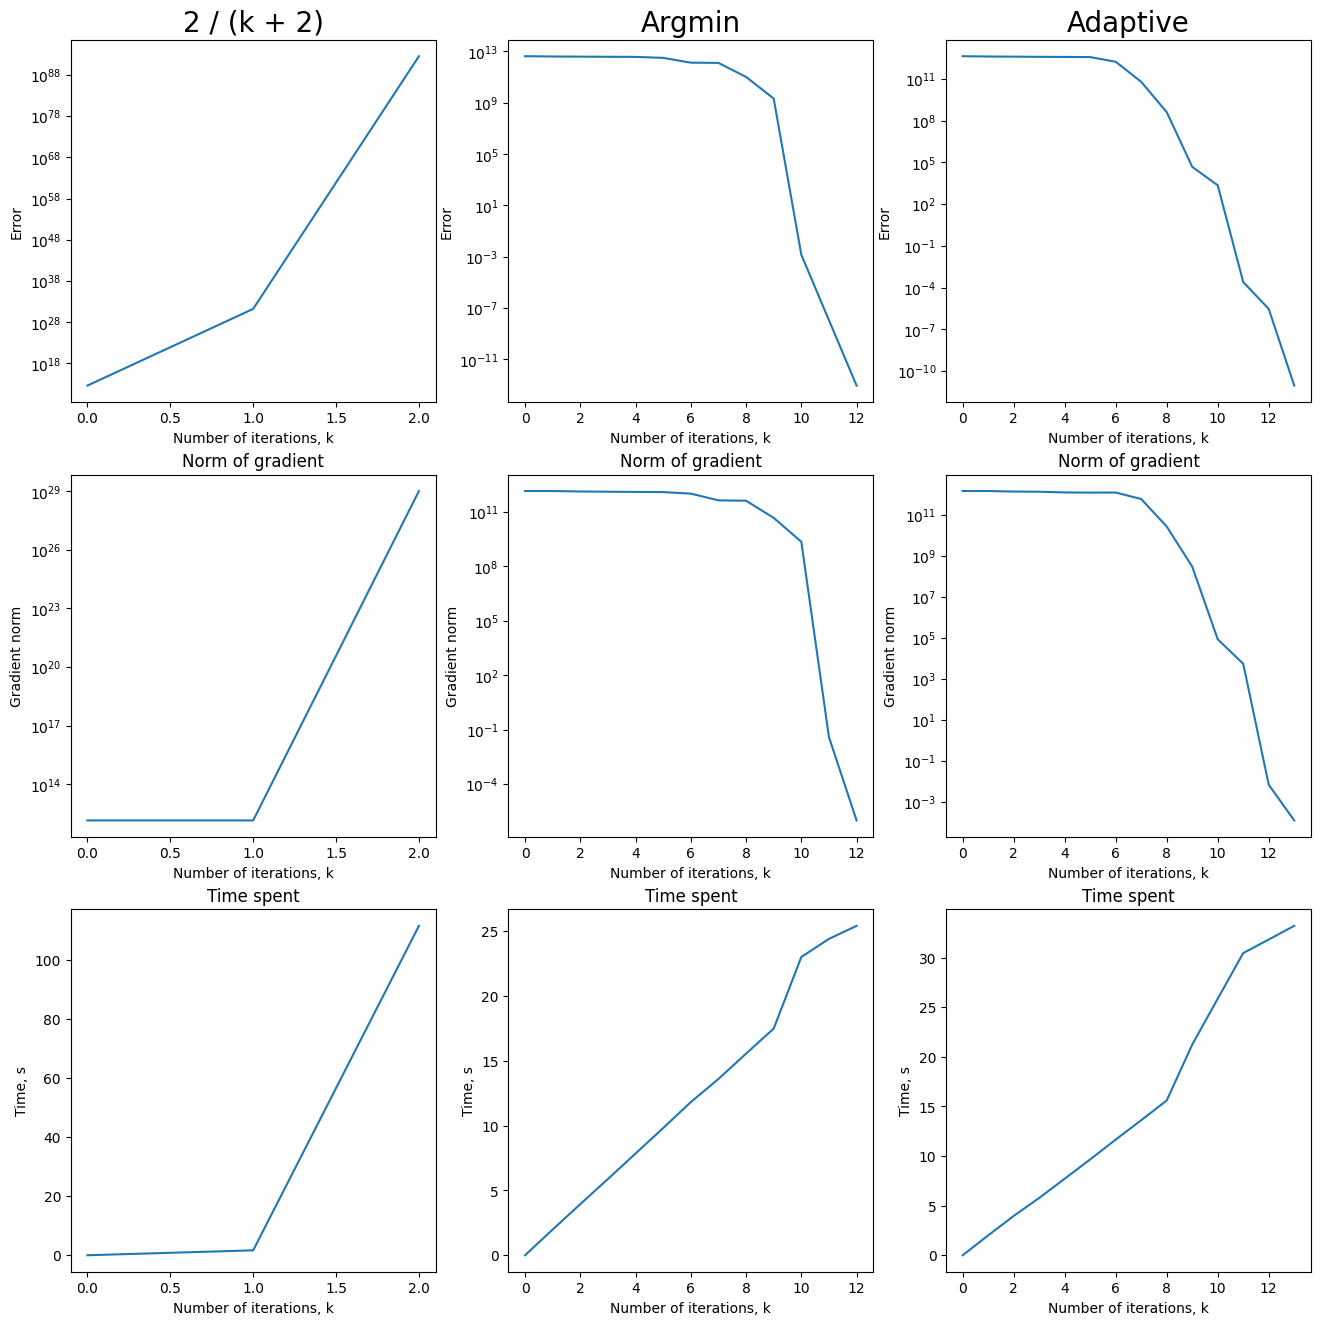

(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [196]:
problem, xmin = random_power_simplex_problem(10, abs(np.random.randn(1000) * 100), 0.0001, 2000)
test_methods(problem, xmin)